In [264]:
import sys
print(sys.executable)

c:\ProgramData\anaconda3\python.exe


In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import calendar 
import seaborn as sns
import matplotlib.ticker as mtick
from scipy import stats

First i will view the head of the data so i can have a look at the column names and shape of the data


In [266]:
df = pd.read_csv("HHDATA_318_0001(HH DATA 30 Mins #1).csv")
print(df.shape)
df.head()


(6270, 59)


,H,OPTIMA Half Hourly DATA,Utility,READING DATE,CHANNEL TYPE,UNITS,00:30,01:00,01:30,02:00,...,22:00,22:30,23:00,23:30,24:00,Daily Total,Max Reading,Min Reading,Data Source,Status
0,D,0201NE002V,Electricity,1/1/2016,Electricity (kWh),kWh,83.7,81.0,82.8,80.1,...,81.9,83.7,82.8,81.9,80.1,4140.0,96.3,79.2,N,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
1,D,0201NE002V,Electricity,1/2/2016,Electricity (kWh),kWh,83.7,82.8,80.1,81.0,...,81.9,84.6,82.8,83.7,81.0,4092.3,91.8,77.4,N,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
2,D,0201NE002V,Electricity,1/3/2016,Electricity (kWh),kWh,81.9,84.6,81.9,80.1,...,81.0,82.8,84.6,81.9,83.7,4083.3,92.7,79.2,N,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
3,D,0201NE002V,Electricity,1/4/2016,Electricity (kWh),kWh,81.9,81.9,79.2,82.8,...,84.6,81.9,84.6,81.9,85.5,4358.7,107.1,77.4,N,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
4,D,0201NE002V,Electricity,1/5/2016,Electricity (kWh),kWh,83.7,83.7,83.7,84.6,...,92.7,89.1,88.2,88.2,90.9,5294.7,157.5,81.0,N,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


# Cleaning and Processing our data


I am now going to do some initial cleaning of the data, for the ease of processing this data later i am converting the reading date to a datetime object 

In [267]:

# Drop rows with any missing values
df = df.dropna()
# Remove duplicate rows
df = df.drop_duplicates()
# Convert 'READING DATE' to datetime
df['READING DATE'] = pd.to_datetime(df['READING DATE'])
# Strip whitespace from string columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

I am now going to remove all entries relating to heat data as i will not be needing these rows in my project. I am also now going to create my seperate data frames for pre,after and during pandemic electricity usage. Additionally i am going to identify and remove anonlymalous data where the Daily Total electricity the min energy is<=0 to deal eith the case of anonlymalous entries in the half-hourly entries . Additionally, I added a column for distinguishing which day of the week each date is, so that i can compare weekdays and weekends later

In [268]:
# Filter DataFrame for Electricity and valid readings
df = df.loc[df["Utility"] == "Electricity"]
df = df.loc[df["Data Source"] == 'O']
df = df.loc[df["Daily Total"] > 0]
df = df.loc[df["Min Reading"] > 0]




Here i am creating my 3 seperate dataframes for my before,during and after pandemic time periods  and adding a column to distinguish which day of the week each data lies on


In [269]:
# Pre-pandemic DataFrame
mask_pre1 = (df['READING DATE'] >= pd.to_datetime("07/11/2017", dayfirst=True)) & (df['READING DATE'] <= pd.to_datetime("29/05/2018", dayfirst=True))
mask_pre2 = (df['READING DATE'] >= pd.to_datetime("17/09/2018", dayfirst=True)) & (df['READING DATE'] <= pd.to_datetime("27/05/2019", dayfirst=True))
mask_pre3 = (df['READING DATE'] >= pd.to_datetime("16/09/2019", dayfirst=True)) & (df['READING DATE'] <= pd.to_datetime("23/03/2020", dayfirst=True))
pre_pandemic_df = df[mask_pre1 | mask_pre2 | mask_pre3].copy()

# During pandemic DataFrame
mask_during1 = (df['READING DATE'] >= pd.to_datetime("24/03/2020", dayfirst=True)) & (df['READING DATE'] <= pd.to_datetime("25/05/2020", dayfirst=True))
mask_during2 = (df['READING DATE'] >= pd.to_datetime("21/09/2020", dayfirst=True)) & (df['READING DATE'] <= pd.to_datetime("23/05/2021", dayfirst=True))
during_pandemic_df = df[mask_during1 | mask_during2].copy()

# After pandemic DataFrame
mask_after1 = (df['READING DATE'] >= pd.to_datetime("20/09/2021", dayfirst=True)) & (df['READING DATE'] <= pd.to_datetime("30/05/2022", dayfirst=True))
mask_after2 = (df['READING DATE'] >= pd.to_datetime("19/09/2022", dayfirst=True)) & (df['READING DATE'] <= pd.to_datetime("26/05/2023", dayfirst=True))
mask_after3 = (df['READING DATE'] >= pd.to_datetime("18/09/2023", dayfirst=True)) & (df['READING DATE'] <= pd.to_datetime("27/05/2024", dayfirst=True))
after_pandemic_df = df[mask_after1 | mask_after2 | mask_after3].copy()



# Describing our data 


Here i am going to return the number of entries of each data frame i have generated


In [270]:
rows_after = after_pandemic_df.shape[0]
rows_during = during_pandemic_df.shape[0]
rows_pre = pre_pandemic_df.shape[0]
print(f"Rows in pre-pandemic DataFrame: {rows_pre}")
print(f"Rows in during-pandemic DataFrame: {rows_during}")
print(f"Rows in after-pandemic DataFrame: {rows_after}")

Rows in pre-pandemic DataFrame: 357
Rows in during-pandemic DataFrame: 307
Rows in after-pandemic DataFrame: 752


# Visualisation and Exploration

I'm going to plot a time series analysis of daily total energy usage at appelton tower drom 07/11/2017 and mark the key covid dates e.g. first and second lockdown 


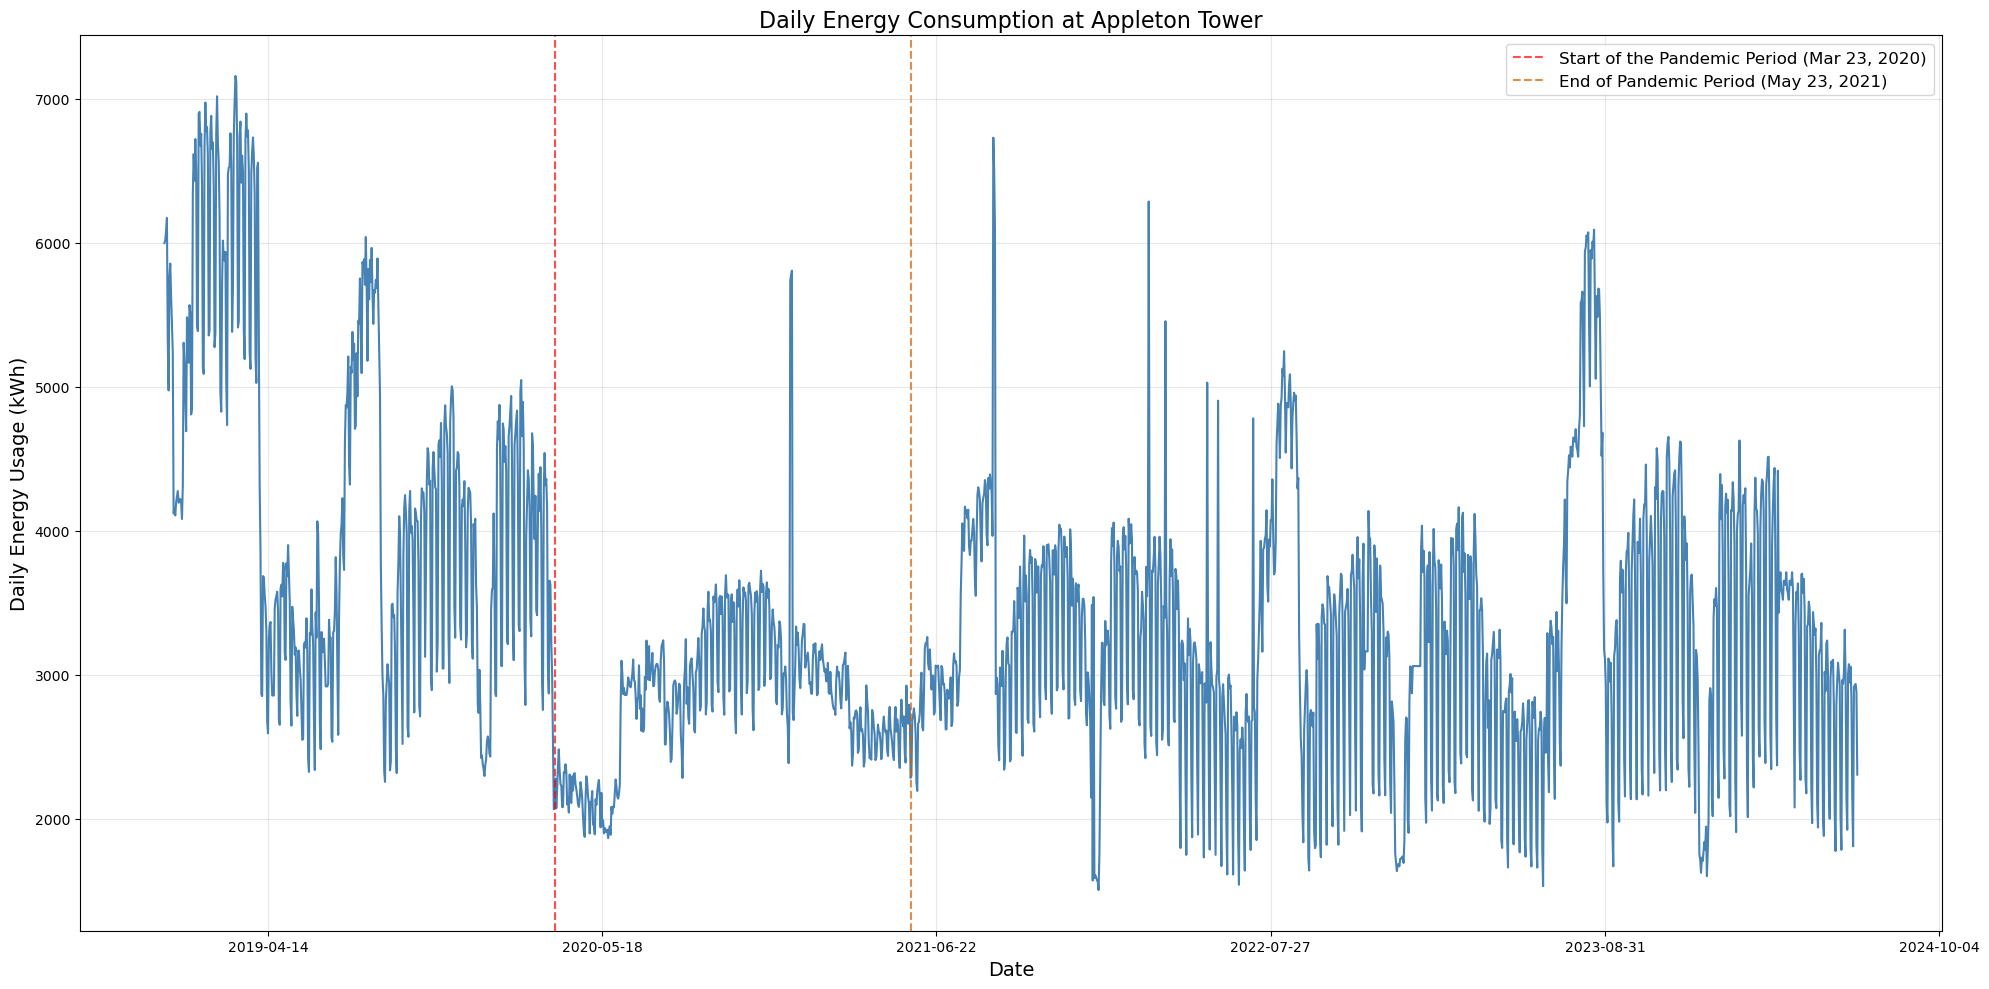

In [271]:
# Create a combined DataFrame for all periods
df_afer_refurb = df.loc[df['READING DATE']>='2017-11-27']
# Create a figure with appropriate size
plt.figure(figsize=(20, 10))

# Plot the daily energy usage 
plt.plot(df_afer_refurb['READING DATE'], df_afer_refurb['Daily Total'], color='steelblue', linewidth=1.5)

# Add vertical lines for key COVID dates
first_lockdown = pd.to_datetime("2020-03-23")  # First UK lockdown
second_lockdown = pd.to_datetime("2021-05-23")  # Second UK lockdown

plt.axvline(x=first_lockdown,color='red', linestyle='--', alpha=0.7, label='Start of the Pandemic Period (Mar 23, 2020)')
plt.axvline(x=second_lockdown, color='#D55E00', linestyle='--', alpha=0.7, label='End of Pandemic Period (May 23, 2021)')

# Improve aesthetics
plt.title('Daily Energy Consumption at Appleton Tower', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Energy Usage (kWh)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Format the date axis to avoid overcrowding
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7))

plt.tight_layout()
plt.show()


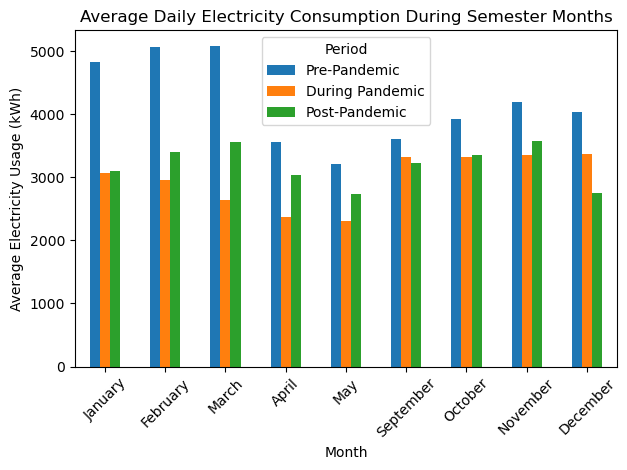

In [272]:
# Group each subset by month (1–12).
pre_pandemic_avg = pre_pandemic_df.groupby(pre_pandemic_df['READING DATE'].dt.month)['Daily Total'].mean()
during_pandemic_avg = during_pandemic_df.groupby(during_pandemic_df['READING DATE'].dt.month)['Daily Total'].mean()
after_pandemic_avg = after_pandemic_df.groupby(after_pandemic_df['READING DATE'].dt.month)['Daily Total'].mean()

#Combine into a single DataFrame
avg_monthly_usage = pd.DataFrame({
    'Pre-Pandemic': pre_pandemic_avg,
    'During Pandemic': during_pandemic_avg,
    'Post-Pandemic': after_pandemic_avg
})

#Only keep semester months
semester_months = [1, 2, 3, 4, 5, 9, 10, 11, 12]
avg_monthly_usage = avg_monthly_usage.reindex(semester_months)

#Replace numeric month index with month names
avg_monthly_usage.index = [calendar.month_name[m] for m in avg_monthly_usage.index]

# Plot a grouped bar chart
avg_monthly_usage.plot(kind='bar', ax=plt.gca())
plt.title('Average Daily Electricity Consumption During Semester Months')
plt.xlabel('Month')
plt.ylabel('Average Electricity Usage (kWh)')
plt.legend(title='Period')

plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

I am now going to create a visualisation comparing the hourly energy use of the three time periods, one set of comparisons for weekdays and one set for weekends 

0.992222404463623
0.8593551114592247


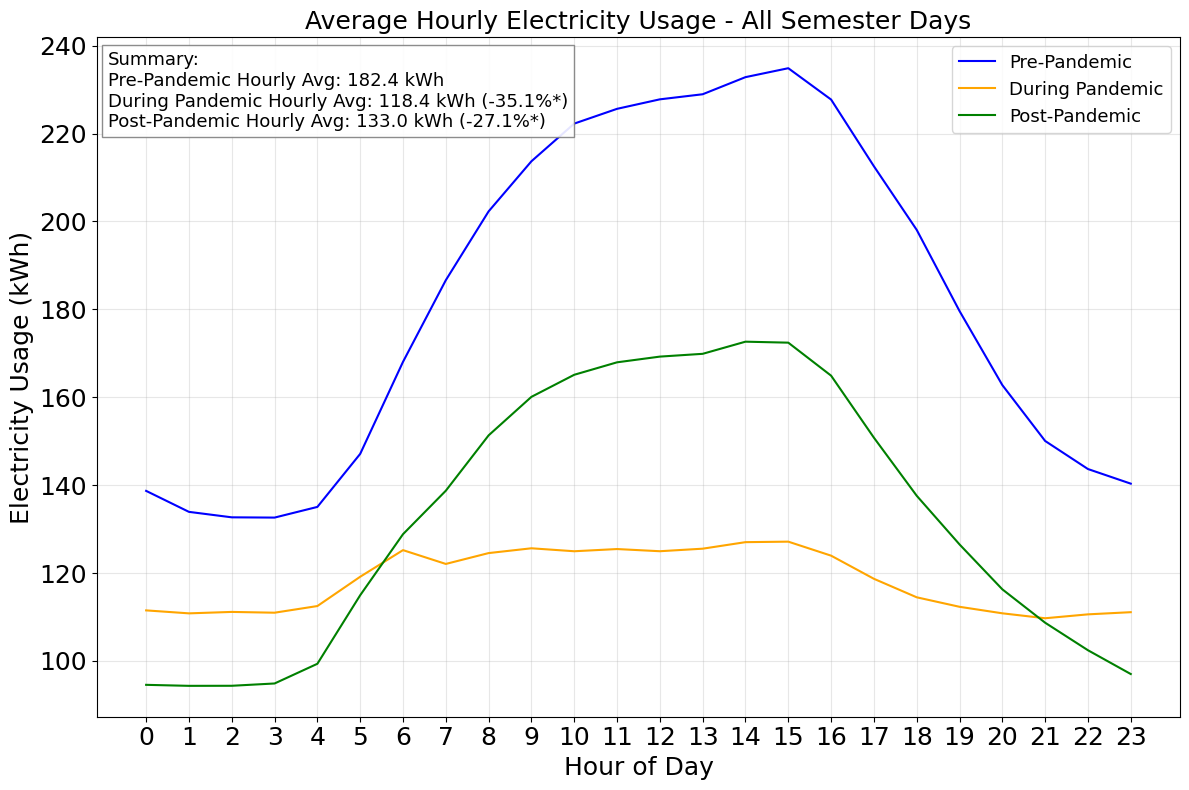

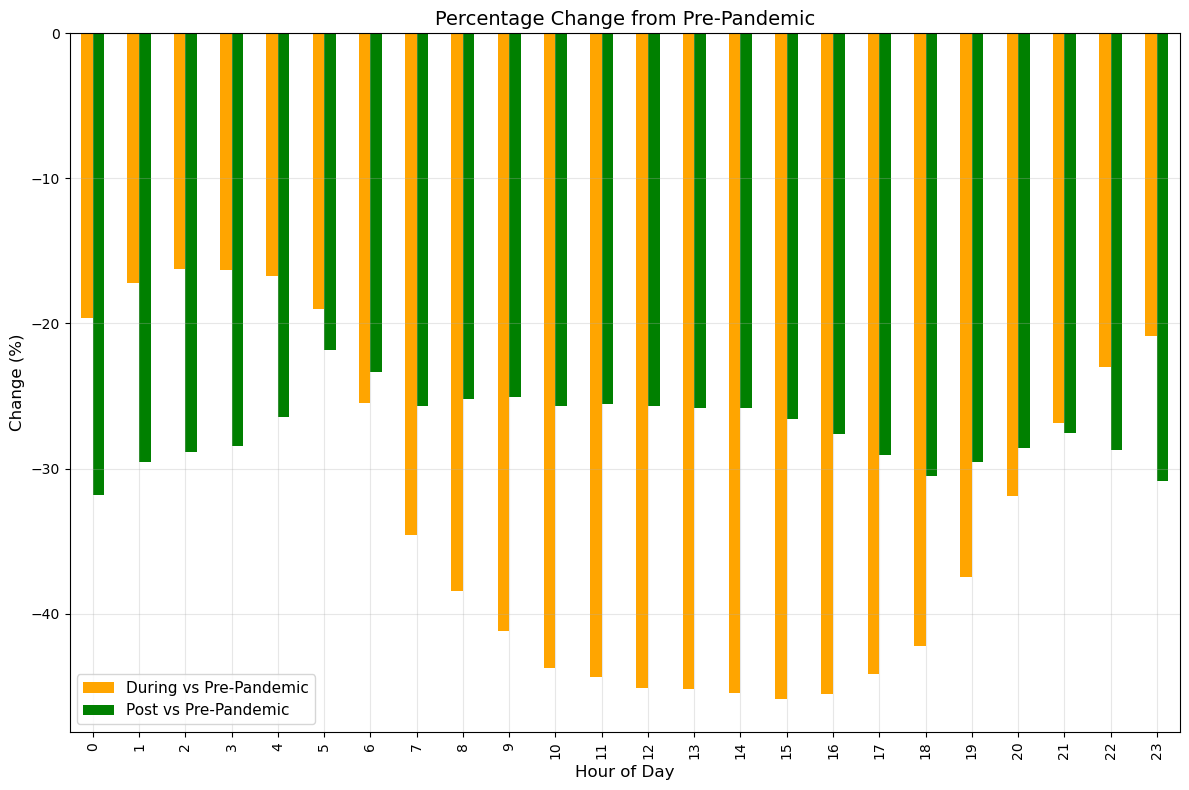

In [273]:
#function to calculate hourly averages
def calculate_hourly_usage(df):
    hourly_usage = {}

    for hour in range(24):
        first_half = f"{hour:02d}:30"
        second_half = f"{(hour+1):02d}:00" if hour < 23 else "24:00"

        
        if first_half in df.columns and second_half in df.columns:
            hourly_values = df[first_half] + df[second_half]
            hourly_usage[hour] = hourly_values.mean()

    return pd.Series(hourly_usage)


pre_hourly = calculate_hourly_usage(pre_pandemic_df)
during_hourly = calculate_hourly_usage(during_pandemic_df)
after_hourly = calculate_hourly_usage(after_pandemic_df)


hourly_usage = pd.DataFrame({
    'Pre-Pandemic': pre_hourly,
    'During Pandemic': during_hourly,
    'Post-Pandemic': after_hourly
})

# Calculate percentage changes
during_pct = ((during_hourly - pre_hourly) / pre_hourly * 100)
after_pct = ((after_hourly - pre_hourly) / pre_hourly * 100)

# Create two figures
fig_usage = plt.figure(figsize=(12, 8))      # Absolute usage
fig_pct = plt.figure(figsize=(12, 8))        # Percentage change

# Absolute usage plot
ax_usage = fig_usage.add_subplot(111)
hourly_usage.plot(ax=ax_usage, color=['blue', 'orange', 'green'])
ax_usage.set_title('Average Hourly Electricity Usage - All Semester Days', fontsize=18)
ax_usage.set_xlabel('Hour of Day', fontsize=18)
ax_usage.set_ylabel('Electricity Usage (kWh)', fontsize=18)
ax_usage.set_xticks(range(24))
ax_usage.legend(fontsize=13)
ax_usage.grid(True, alpha=0.3)
ax_usage.tick_params(axis='x', labelsize=18)
ax_usage.tick_params(axis='y', labelsize=18)


# Percentage change plot
ax_pct = fig_pct.add_subplot(111)
pd.DataFrame({
    'During vs Pre-Pandemic': during_pct,
    'Post vs Pre-Pandemic': after_pct
}).plot(ax=ax_pct, color=['orange', 'green'], kind='bar')
ax_pct.set_title('Percentage Change from Pre-Pandemic', fontsize=14)
ax_pct.set_xlabel('Hour of Day', fontsize=12)
ax_pct.set_ylabel('Change (%)', fontsize=12)
ax_pct.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax_pct.legend(fontsize=11)
ax_pct.grid(True, alpha=0.3)


hourly_avg = {col: hourly_usage[col].mean() for col in hourly_usage.columns}

#summary text
text = f"Summary:\n"
text += f"Pre-Pandemic Hourly Avg: {hourly_avg['Pre-Pandemic']:.1f} kWh\n"
text += f"During Pandemic Hourly Avg: {hourly_avg['During Pandemic']:.1f} kWh ({(hourly_avg['During Pandemic']/hourly_avg['Pre-Pandemic']-1)*100:.1f}%*)\n"
text += f"Post-Pandemic Hourly Avg: {hourly_avg['Post-Pandemic']:.1f} kWh ({(hourly_avg['Post-Pandemic']/hourly_avg['Pre-Pandemic']-1)*100:.1f}%*)"


ax_usage.text(0.01, 0.98, text, transform=ax_usage.transAxes, 
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'), 
        fontsize=13)

# Adjust layout for each figure
fig_usage.tight_layout()
fig_pct.tight_layout()




print(np.corrcoef(after_hourly, pre_hourly)[0][1])
print(np.corrcoef(pre_hourly, during_hourly)[0][1])


The box and violin  plots compare the distribution (median, quartiles, and outliers) of daily energy usage for each period. They help highlight differences in variability and central tendency.

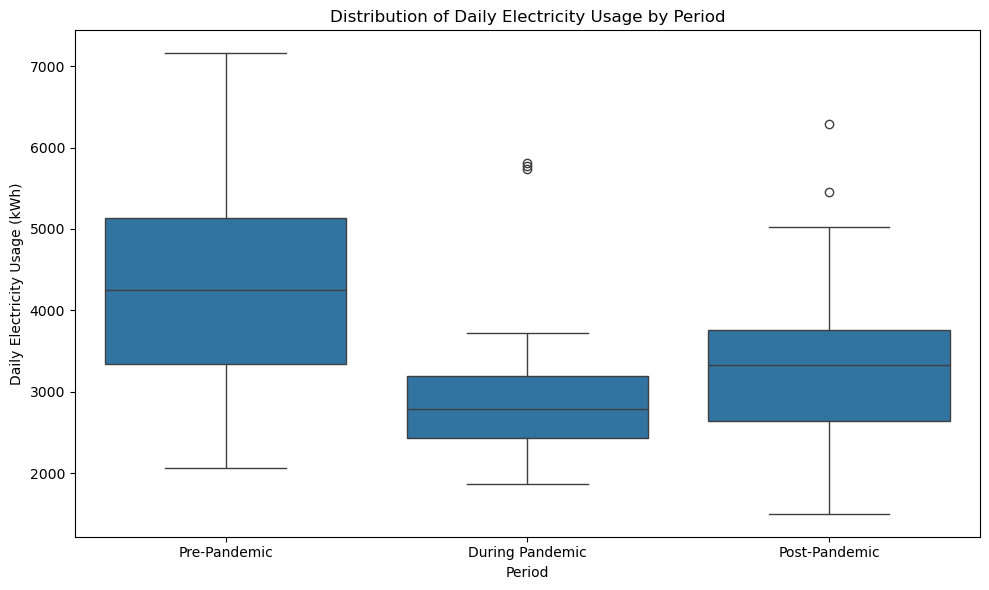

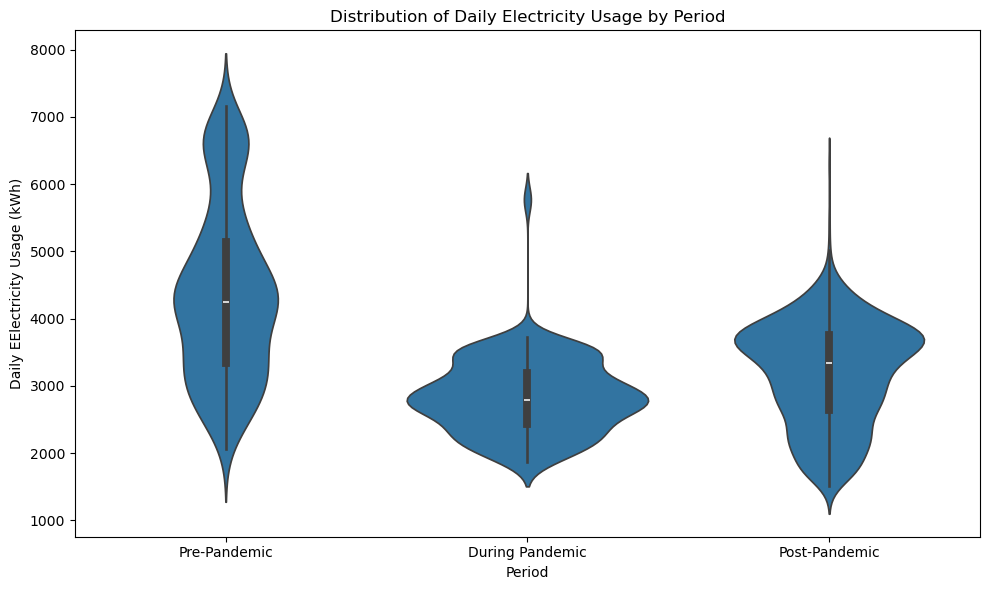

In [274]:
pre_daily_df = pre_pandemic_df.copy()
pre_daily_df['Period'] = 'Pre-Pandemic'
during_daily_df = during_pandemic_df.copy()
during_daily_df['Period'] = 'During Pandemic'
after_daily_df = after_pandemic_df.copy()
after_daily_df['Period'] = 'Post-Pandemic'

combined_daily = pd.concat([pre_daily_df, during_daily_df, after_daily_df])
combined_daily = combined_daily.set_index('READING DATE').resample('D').agg({
    'Daily Total': 'sum',
    'Period': 'first'
}).reset_index()

# Box Plot
plt.figure(figsize=(10,6))
sns.boxplot(x='Period', y='Daily Total', data=combined_daily)
plt.title('Distribution of Daily Electricity Usage by Period')
plt.ylabel('Daily Electricity Usage (kWh)')
plt.tight_layout()
plt.show()

# Violin Plot
plt.figure(figsize=(10,6))
sns.violinplot(x='Period', y='Daily Total', data=combined_daily)
plt.title('Distribution of Daily Electricity Usage by Period')
plt.ylabel('Daily EElectricity Usage (kWh)')
plt.tight_layout()
plt.show()


# Statistical inference

I am going to run some independent T-tests


first i am going to run a sharpiro-wilk test to ensure the data is Normal even though, in my report, to save word count i am just going to assume normality by the C.L.T 

In [275]:
data = avg_monthly_usage


print("Columns in the dataset:")
print(data.columns)


def shapiro_test(series, label):
    clean_data = series.dropna()
    stat, p_value = stats.shapiro(clean_data)
    print(f"\nShapiro-Wilk Test for {label}:")
    print(f"Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value > 0.05:
        print(f"{label} appears to be normally distributed (fail to reject H0).")
    else:
        print(f"{label} does not appear to be normally distributed (reject H0).")
    return stat, p_value


for col in data.columns:
    shapiro_test(data[col], col)


paired = data[['Pre-Pandemic', 'During Pandemic']].dropna()
differences = paired['Pre-Pandemic'] - paired['During Pandemic']
stat_diff, p_diff = stats.shapiro(differences)
print("\nShapiro-Wilk Test for differences (Pre-Pandemic - During Pandemic):")
print(f"Test Statistic: {stat_diff:.4f}, p-value: {p_diff:.4f}")
if p_diff > 0.05:
    print("Differences appear to be normally distributed (fail to reject H0).")
else:
    print("Differences do not appear to be normally distributed (reject H0).")

   
    paired_pre_post = data[['Pre-Pandemic', 'Post-Pandemic']].dropna()
    differences_pre_post = paired_pre_post['Pre-Pandemic'] - paired_pre_post['Post-Pandemic']
    stat_diff_pre_post, p_diff_pre_post = stats.shapiro(differences_pre_post)
    print("\nShapiro-Wilk Test for differences (Pre-Pandemic - Post-Pandemic):")
    print(f"Test Statistic: {stat_diff_pre_post:.4f}, p-value: {p_diff_pre_post:.4f}")
    if p_diff_pre_post > 0.05:
        print("Differences appear to be normally distributed (fail to reject H0).")
    else:
        print("Differences do not appear to be normally distributed (reject H0).")

    
    paired_during_post = data[['During Pandemic', 'Post-Pandemic']].dropna()
    differences_during_post = paired_during_post['During Pandemic'] - paired_during_post['Post-Pandemic']
    stat_diff_during_post, p_diff_during_post = stats.shapiro(differences_during_post)
    print("\nShapiro-Wilk Test for differences (During Pandemic - Post-Pandemic):")
    print(f"Test Statistic: {stat_diff_during_post:.4f}, p-value: {p_diff_during_post:.4f}")
    if p_diff_during_post > 0.05:
        print("Differences appear to be normally distributed (fail to reject H0).")
    else:
        print("Differences do not appear to be normally distributed (reject H0).")

   

Columns in the dataset:
Index(['Pre-Pandemic', 'During Pandemic', 'Post-Pandemic'], dtype='object')

Shapiro-Wilk Test for Pre-Pandemic:
Test Statistic: 0.9178, p-value: 0.3745
Pre-Pandemic appears to be normally distributed (fail to reject H0).

Shapiro-Wilk Test for During Pandemic:
Test Statistic: 0.8402, p-value: 0.0581
During Pandemic appears to be normally distributed (fail to reject H0).

Shapiro-Wilk Test for Post-Pandemic:
Test Statistic: 0.9260, p-value: 0.4442
Post-Pandemic appears to be normally distributed (fail to reject H0).

Shapiro-Wilk Test for differences (Pre-Pandemic - During Pandemic):
Test Statistic: 0.9210, p-value: 0.4003
Differences appear to be normally distributed (fail to reject H0).


In [276]:

data = avg_monthly_usage


def perform_paired_ttest(data1, data2, label1, label2):
    # Create a DataFrame to ensure paired comparisons
    paired = pd.DataFrame({'data1': data1, 'data2': data2}).dropna()
    
    
    differences = paired['data1'] - paired['data2']
    
    
    t_stat, p_value = stats.ttest_rel(paired['data1'], paired['data2'])
    
    # Number of paired observations and degrees of freedom
    n = len(differences)
    dof = n - 1
    
    # Mean and standard deviation of the differences
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)
    
    # Calculate Cohen's d for paired samples (mean difference / standard deviation of differences)
    cohens_d = mean_diff / std_diff if std_diff != 0 else np.nan
    
    # Calculate the 95% confidence interval for the mean difference
    se = std_diff / np.sqrt(n)
    t_critical = stats.t.ppf(0.975, dof)
    margin_of_error = t_critical * se
    ci_lower = mean_diff - margin_of_error
    ci_upper = mean_diff + margin_of_error
    
    
    
    # Print the paired t-test results
    print(f"\n{label1} vs {label2} (Paired):")
    print(f"Mean difference: {mean_diff:.2f}")
    print(f"t-statistic: {t_stat:.4f}, df: {dof}")
    print(f"p-value: {p_value:.4f} ({'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05)")
    print(f"Cohen's d: {cohens_d:.4f}")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    
    return {
        'comparison': f"{label1} vs {label2} (Paired)",
        'mean_diff': mean_diff,
        't_stat': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }


paired_pre_during = data[['Pre-Pandemic', 'During Pandemic']].dropna()
paired_pre_post = data[['Pre-Pandemic', 'Post-Pandemic']].dropna()
paired_during_post = data[['During Pandemic', 'Post-Pandemic']].dropna()


print("\nPaired T-Test Results:")
pre_vs_during = perform_paired_ttest(paired_pre_during['Pre-Pandemic'], paired_pre_during['During Pandemic'],
                                     "Pre-pandemic", "During-pandemic")
pre_vs_post = perform_paired_ttest(paired_pre_post['Pre-Pandemic'], paired_pre_post['Post-Pandemic'],
                                   "Pre-pandemic", "Post-pandemic")
during_vs_post = perform_paired_ttest(paired_during_post['During Pandemic'], paired_during_post['Post-Pandemic'],
                                      "During-pandemic", "Post-pandemic")



Paired T-Test Results:

Pre-pandemic vs During-pandemic (Paired):
Mean difference: 1200.93
t-statistic: 4.8990, df: 8
p-value: 0.0012 (Significant at α=0.05)
Cohen's d: 1.6330
95% CI: [635.65, 1766.21]

Pre-pandemic vs Post-pandemic (Paired):
Mean difference: 974.60
t-statistic: 5.2416, df: 8
p-value: 0.0008 (Significant at α=0.05)
Cohen's d: 1.7472
95% CI: [545.83, 1403.37]

During-pandemic vs Post-pandemic (Paired):
Mean difference: -226.33
t-statistic: -1.5084, df: 8
p-value: 0.1699 (Not significant at α=0.05)
Cohen's d: -0.5028
95% CI: [-572.35, 119.68]
